# Data Collection

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features 
y = car_evaluation.data.targets 

df = pd.concat([X, y], axis = 1)

print(df.head())

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


# Data Cleaning

### Scoping the Data

In [4]:
print(df.describe())

       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh  vhigh     2       2    small    low  unacc
freq      432    432   432     576      576    576   1210


In [5]:
print(df.isnull().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None


In [7]:
print(df['class'].value_counts())

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


#### Notes:

- There is no essential Data Cleansing to do as there is no nulls or rubbish data.
- However, for clarification I will rename the values in the target variable 'class'.
- We are also working with a very imbalanced data set. So this will have to be taken into account later in data preprocessing and model development.

### Data Cleaning - 'class'

In [8]:
def replace_values(x):
    if x == 'unacc':
        return 'unacceptable'
    elif x == 'acc':
        return 'acceptable'
    elif x == 'vgood':
        return 'very good'
    else:
        return x
    
df['class'] = df['class'].apply(replace_values)

print(df['class'].value_counts())

unacceptable    1210
acceptable       384
good              69
very good         65
Name: class, dtype: int64


# Data Exploration:

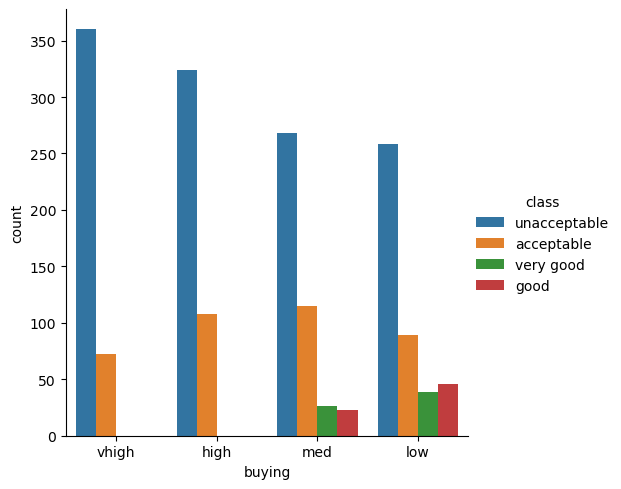

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data = df, hue = 'class', x = 'buying', kind = 'count')
plt.show()

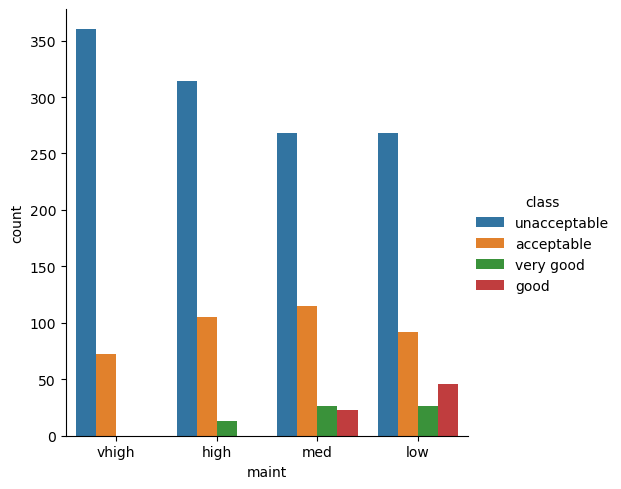

In [10]:
sns.catplot(data = df, x = 'maint', hue = 'class', kind = 'count')
plt.show()

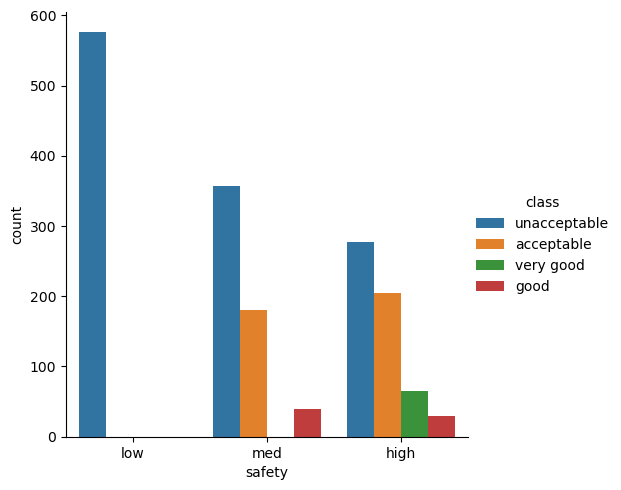

In [11]:
sns.catplot(data = df, x = 'safety', hue = 'class', kind = 'count')
plt.show()

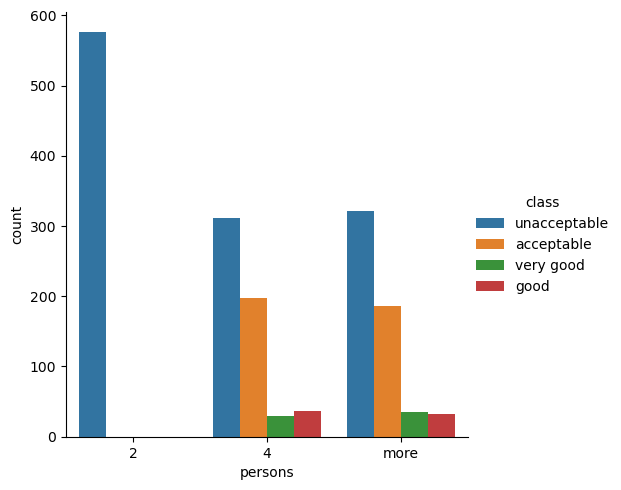

In [12]:
sns.catplot(data = df, x = 'persons', hue = 'class', kind = 'count')
plt.show()

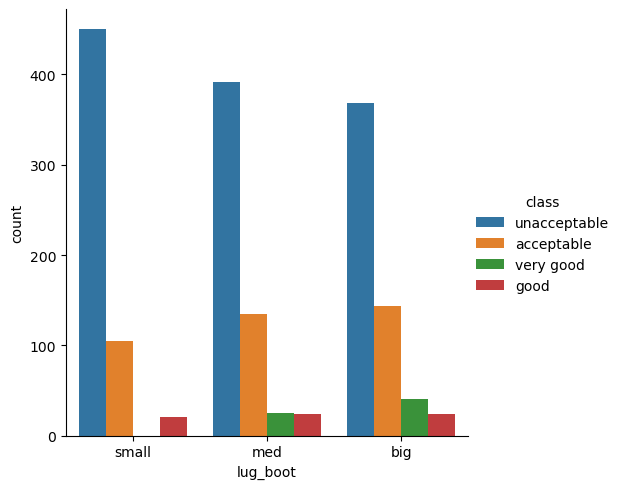

In [13]:
sns.catplot(data = df, x = 'lug_boot', hue = 'class', kind = 'count')
plt.show()

#### Notes:

- The classes as we know are unbalanced which effects the counts, however we can see that if a car has only 2 seats and low safety. They're likely to be classed as unacceptable as thats the only class represented for these 2 features.
- Good and Very Good classes only become represented when the buying price is low/medium, whereas very good class only exists where maintenence costs is medium/low.
- Therefore, at the distant ends of the scales the above features will be key.
- Acceptable class vehicules are spread amongst most categories with a fairly equal distribution so this class may be difficult to predict, so models may perform worse at this class.
- Generally, the distribution of the unacceptable class decreases within the features as theres more space for luggage and people, and lower costs. Therefore, we would expect to see this class represented less as these features abide by the above.

# Data Preprocessing

### Data Preprocessing - Encoding 

In [14]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_unprocessed = df.drop(columns = 'class')
y_unprocessed = df['class']

ordinalencoder = OrdinalEncoder()
X_processed_array = ordinalencoder.fit_transform(X_unprocessed)
X_processed = pd.DataFrame(data = X_processed_array, columns = X_unprocessed.columns)


labelencoder = LabelEncoder()
y_processed_array = labelencoder.fit_transform(y_unprocessed)


X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed_array, test_size = 0.2, stratify = y_processed_array,
                                                   random_state = 42)

print(f'Train sample: {X_train.shape}')
print(f'Test sample: {X_test.shape}')

Train sample: (1382, 6)
Test sample: (346, 6)


#### Notes:

- Encoded the data ordinally for the features, and by label for the target variable 'class'.
- Split and stratified so that the test and train have proportionately equal number of classes for the target variable.
- Remembering to set the random_state for reproducability.

### Data Preprocessing - SMOTE

In [15]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [16]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print('Orginal class representation', Counter(y_train))
print('Resampled dataset shape', Counter(y_sm))

Orginal class representation Counter({2: 968, 0: 307, 1: 55, 3: 52})
Resampled dataset shape Counter({0: 968, 2: 968, 1: 968, 3: 968})


# Model Development 

### Logistic Regression - Without SMOTE training set

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight = 'balanced', random_state=42)

log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)

print(f'Logistic Regression without SMOTE score = {log_reg_score}')

Logistic Regression without SMOTE score = 0.546242774566474


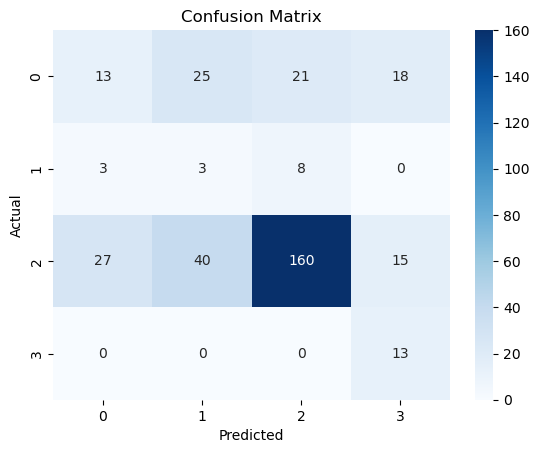

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

log_reg_y_pred = log_reg.predict(X_test)

log_reg_conf_matr = confusion_matrix(y_test, log_reg_y_pred)

sns.heatmap(log_reg_conf_matr, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import classification_report

clf_class_report = classification_report(y_test, log_reg_y_pred)

print(clf_class_report)

              precision    recall  f1-score   support

           0       0.30      0.17      0.22        77
           1       0.04      0.21      0.07        14
           2       0.85      0.66      0.74       242
           3       0.28      1.00      0.44        13

    accuracy                           0.55       346
   macro avg       0.37      0.51      0.37       346
weighted avg       0.67      0.55      0.59       346



#### Notes:

- The Logistic Regression model without SMOTE performed predictably poorly, with only a 54.6% accuracy. This would be insufficient in adding any business value and is even worse in comparison to the most frequent dummy classifier, which would score 70% on the test set.
- This although is expected as logistic regression is typically poor at handling class imbalances and the multiclass classification exagerates it further.
- The worse performing class via f1 score was class 1 (0.07) which had the second least instances in the test set (14), whilst the highest was class 2 (0.74) which had the most amount of instances (242).

### Logistic Regression with SMOTE

In [20]:
log_reg.fit(X_sm, y_sm)

log_reg_score_sm = log_reg.score(X_test, y_test)

print(f'Logistic Regression with SMOTE score = {log_reg_score_sm}')

Logistic Regression with SMOTE score = 0.5664739884393064


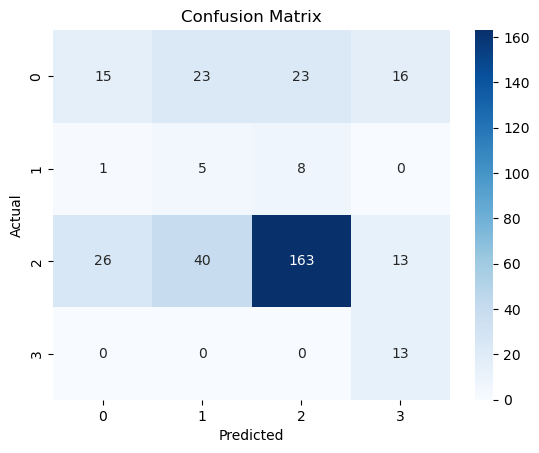

In [21]:
log_reg_sm_y_pred = log_reg.predict(X_test)

log_reg_sm_conf_matr = confusion_matrix(y_test, log_reg_sm_y_pred)

sns.heatmap(log_reg_sm_conf_matr, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
sm_class_rpt = classification_report(y_test, log_reg_sm_y_pred)

print(sm_class_rpt)

              precision    recall  f1-score   support

           0       0.36      0.19      0.25        77
           1       0.07      0.36      0.12        14
           2       0.84      0.67      0.75       242
           3       0.31      1.00      0.47        13

    accuracy                           0.57       346
   macro avg       0.40      0.56      0.40       346
weighted avg       0.68      0.57      0.60       346



### Notes:

- The Logistic Regression Model trained on SMOTE data did perform marginally better across the board in terms of overall accuracy score, and f1 score for all the classes. Indicating that the SMOTE training set did go some of the way in improving performance.
- However, the improvements were insignificant overall and the model only improved by 2% with the worse f1 score being 0.12 (for class 1 again), an improvment but still exceptionally poor performing.
- Therefore, going forward I would disregard Logistic Regression for this problem, and test RandomForest as this model functions generally well on unbalanced classes without the need to use SMOTE.

### Random Forest 

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train, y_train)

rfc_score = rfc.score(X_test, y_test)

print(f'RFC score = {rfc_score}')

RFC score = 0.9826589595375722


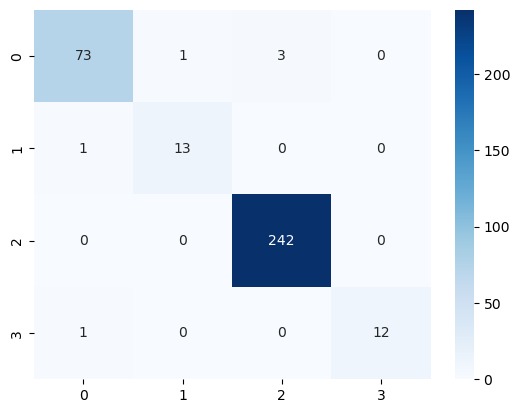

In [24]:
rfc_y_pred = rfc.predict(X_test)

rfc_conf_matrix = confusion_matrix(y_test, rfc_y_pred)

sns.heatmap(rfc_conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel = 'Predictions'
plt.ylabel = 'True Values'
plt.title = 'RFC Confusion Matrix'
plt.show()

In [25]:
rfc_class_rpt = classification_report(y_test, rfc_y_pred)
print(rfc_class_rpt)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        77
           1       0.93      0.93      0.93        14
           2       0.99      1.00      0.99       242
           3       1.00      0.92      0.96        13

    accuracy                           0.98       346
   macro avg       0.97      0.95      0.96       346
weighted avg       0.98      0.98      0.98       346



### Notes:

- As predicted, the Random Forest Classifier performed significantly better due it it handling the less frequent classes better.
- The overal accuracy of 98% signifies it would be ready for quick deployment.
- The problematic class (class 1 with 14 instances), is now returning an F1 score of 0.93. The lowest but still exceptionally strong and incomparably better than the logistic regression model with or without SMOTE.

# Decision Threshold

In [26]:
from collections import Counter

element_counts_unprocessed = Counter(y_unprocessed)
element_counts_processed = Counter(y_processed_array)

print(element_counts_unprocessed)
print(element_counts_processed)

Counter({'unacceptable': 1210, 'acceptable': 384, 'good': 69, 'very good': 65})
Counter({2: 1210, 0: 384, 1: 69, 3: 65})


In [30]:
import numpy as np

# Returns a 2d array with the probabilies for each instance and class.
y_pred_proba = rfc.predict_proba(X_test)

# Sets the threshold
threshold = 0.7

# Returns the predicted class based on maximum probability
y_pred_max_prob = np.max(y_pred_proba, axis=1)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Filters predictions where the highest probability exceeds the threshold
high_confidence_idx = y_pred_max_prob >= threshold
y_test_high_confidence = y_test[high_confidence_idx]
y_pred_high_confidence = y_pred_classes[high_confidence_idx]

print(y_pred_proba[0:20])
print(y_pred_max_prob[0:20])
print(y_pred_classes[0:20])
print(high_confidence_idx[0:20])
print(y_test_high_confidence[0:20])
print(y_pred_high_confidence[0:20])

[[0.08 0.9  0.02 0.  ]
 [0.09 0.   0.91 0.  ]
 [0.17 0.   0.83 0.  ]
 [0.   0.   1.   0.  ]
 [0.85 0.   0.02 0.13]
 [0.   0.   1.   0.  ]
 [0.03 0.   0.97 0.  ]
 [0.74 0.06 0.2  0.  ]
 [0.05 0.01 0.92 0.02]
 [0.31 0.   0.69 0.  ]
 [0.01 0.   0.99 0.  ]
 [0.   0.   1.   0.  ]
 [0.35 0.   0.65 0.  ]
 [0.   0.   1.   0.  ]
 [0.16 0.07 0.02 0.75]
 [0.02 0.   0.98 0.  ]
 [0.82 0.   0.01 0.17]
 [0.01 0.   0.99 0.  ]
 [0.   0.   1.   0.  ]
 [0.04 0.   0.96 0.  ]]
[0.9  0.91 0.83 1.   0.85 1.   0.97 0.74 0.92 0.69 0.99 1.   0.65 1.
 0.75 0.98 0.82 0.99 1.   0.96]
[1 2 2 2 0 2 2 0 2 2 2 2 2 2 3 2 0 2 2 2]
[ True  True  True  True  True  True  True  True  True False  True  True
 False  True  True  True  True  True  True  True]
[1 2 2 2 0 2 2 0 2 2 2 2 3 2 0 2 2 2 2 2]
[1 2 2 2 0 2 2 0 2 2 2 2 3 2 0 2 2 2 2 2]


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics for high-confidence predictions (macro-averaging for multiclass)
precision = precision_score(y_test_high_confidence, y_pred_high_confidence, average="macro")
recall = recall_score(y_test_high_confidence, y_pred_high_confidence, average="macro")
f1 = f1_score(y_test_high_confidence, y_pred_high_confidence, average="macro")

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Precision (macro): 1.0
Recall (macro): 1.0
F1 Score (macro): 1.0


In [36]:
print(f'Original Test Size = {len(y_test)}')
print(f'Test Size which we can automate = {len(y_test_high_confidence)}')

print(f'Test Size which we can automate = {(len(y_test_high_confidence)/len(y_test)):.4f}')

Original Test Size = 346
Test Size which we can automate = 310
Test Size which we can automate = 0.8960


#### Notes:

- The above indicates that if we set the threshold at 0.7 we can classify 310/346 in the test set with 100% accuracy via the precision, recall, and f1 score.
- This means we can automate the decisions for roughly 90% of the test cases. 
- In a business context this means we could automate buying/not buying roughly 90% of the cars based on their class. Meaning 10% will go to manual review.